# Onderzoek vragen

Wij hebben de volgende onderzoek vragen bedacht.

1. In hoeverre is de score van een Portugese Red te voorspellen op basis van de chemische kenmerken?
2. (Bonus) Kan men op basis van eigenschappen van eerder gereviewde wijnen voorspellen wat een recensent van een wijn zal vinden.
3. Welk effect heeft weer over de jaren heen effect op de wijn score die reviewers geven in punten?
4. Kan je op basis van score en prijs welke regio de wijn zijn oorsprong.


# Data verkening 
Als eers hebben wij het csv naar een exel bestand omgezet en de data bekeken. Hier uit ondeketen wij de volgende punten.

Wij er achter gekomen dat het moeilijk is om een wijn te identificeren. Zo kan een wijn uit hetzelfde jaar met dezelfde naam gereviewed door dezelfde persoon uit de zelfde streek andere chemische eigenschappen hebben. Dit roept vragen op. Namelijk zijn de wijnen hetzelfde en zo ja. Klopt de meting van de chemische eigenschappen dan wel. Wij hebben besloten er van uit te gaan dat wij de chemische eigenschappen kunnen vertrouwen. Dit omdat wij anders dusdanig beperkt zijn dat wij geen interessante correlaties kunnen maken en de opdracht dus niet voldaan kan worden. Wij weten dus niet in hoeverre de namen correct zijn. Dit kan voor problemen zorgen bij ML. 
Jaartal is niet specifiek aangegeven maar kan wel zeer bruikbaar zijn. Naar verkenning zijn wij er achter gekomen dat een titel wel vaak een jaar aangeeft. Wij hebben toen code geschreven om te kijken welke titels geen jaar bevat dit bleken er 4 te zijn.
Na verkenning zijn wij er achter gekomen dat provincies niet altijd bestaande provincies zijn maar dat er ook regio’s en onbruikbare waardes tussen zitten. Dit zorgt er dus voor dat wij niet soepel weerdata voor die regio kunnen opvragen en maakt een correlatie zoeken tussen weer in een regio en de  qualiteit van de wijn erg moeilijk Daarom kiezen wij ervoor om data van de hoofdstad te gebruiken i.p.v. data van verschillende plaatsen. De data van de hoofdstad (Lissabon) hebben we gevonden op www7.ncdc.noaa.gov/ dit is National Climatic Data Center van de United states department of commerce. Hier hebben wij de data van Lissabon van 1990 tot 2018 kunnen vinden.


In [32]:
# importeer nodige libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

__INTERNE RED WINES DATASET__

In [33]:
# lees het bestand in
redwines = pd.read_csv("redwine.csv", delimiter=";", encoding='iso-8859-1')

# verwijder onnodige kolommen
redwines.drop(['country','variety','id'],axis=1, inplace=True)
redwines.dropna(inplace=True)

# voeg jaartal toe als aparte kolom, en verwijder nan rijen voor jaren (2465 naar 2461)
redwines['year'] = redwines['title'].str.extract(r"([1][9][9]\d|[2][0][0,1,2]\d)")
redwines = redwines[redwines['year'].notnull()]
redwines['year'] = redwines['year'].astype(int)
redwines['count'] = 1

# lees tabel statistieken uit
redwines.describe()

,points,price,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,year,count
count,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.000000,2060.0
mean,88.860194,24.703398,8.349272,0.529723,2.574587,0.087831,16.008252,47.775243,3.310869,0.662427,2011.600485,1.0
std,2.947800,25.716501,1.742572,0.180143,1.419112,0.047329,10.423659,33.478012,0.155111,0.173984,2.812603,0.0
min,81.000000,5.000000,4.600000,0.120000,0.900000,0.012000,1.000000,6.000000,2.740000,0.330000,1996.000000,1.0
25%,87.000000,12.000000,7.100000,0.400000,1.900000,0.070000,8.000000,23.000000,3.210000,0.550000,2010.000000,1.0
50%,88.000000,17.000000,7.900000,0.520000,2.200000,0.079000,14.000000,38.000000,3.305000,0.620000,2012.000000,1.0
75%,91.000000,28.000000,9.300000,0.635000,2.600000,0.090250,21.000000,65.000000,3.400000,0.730000,2014.000000,1.0
max,100.000000,450.000000,15.900000,1.580000,15.500000,0.610000,72.000000,289.000000,4.010000,2.000000,2016.000000,1.0


__EXTERNE WEER DATASET__

In [34]:
# lees de externe dataset in
weather_conditions = pd.read_csv("weatherdata_lisbon.csv", delimiter=";", encoding='iso-8859-1')

# drop onbruikbare rijen en hernoem kolommen
weather_conditions.drop(['STN---','Unnamed: 5','Unnamed: 7','GUST','PRCP','SNDP','VISIB'], axis=1,inplace=True)
weather_conditions.dropna(inplace=True)
weather_conditions.rename(columns={'YEARMODA': 'Year','DEWP':'Dewpoint Temperature','TEMP': 'Temperature','MAX':'Max Temperature','MIN':'Min Temperature','WDSP':'Windspeed','MXSPD':'Max Windspeed'},inplace=True)

# cleanup and transform data types
# also convert fahrenheit to celsius
weather_conditions['Max Temperature'] = (weather_conditions['Max Temperature'].str.replace(',','.').str.rstrip("*").astype(float) - 32) / 1.8
weather_conditions['Min Temperature'] = (weather_conditions['Min Temperature'].str.replace(',','.').str.rstrip("*").astype(float) - 32) / 1.8
weather_conditions['Temperature'] = (weather_conditions['Temperature'].str.replace(',','.').astype(float) - 32) / 1.8
weather_conditions['Dewpoint Temperature'] = (weather_conditions['Dewpoint Temperature'].str.replace(',','.').astype(float) - 32) / 1.8
weather_conditions['Windspeed'] = weather_conditions['Windspeed'].str.replace(',','.').astype(float)
weather_conditions['Max Windspeed'] = weather_conditions['Max Windspeed'].str.replace(',','.').astype(float)
weather_conditions['Year']= pd.to_datetime(weather_conditions['Year'].astype(str), format='%Y-%m-%d')

# FRSHTT = Frost, Rain, Snow, Hail, Thunder, Thornado
weather_conditions['FRSHTT'] = weather_conditions['FRSHTT'].apply(lambda x: '{0:0>6}'.format(x))
weather_conditions['Frost'] = weather_conditions['FRSHTT'].str[0].astype(float)
weather_conditions['Rain'] = weather_conditions['FRSHTT'].str[1].astype(float)
weather_conditions['Snow'] = weather_conditions['FRSHTT'].str[2].astype(float)
weather_conditions['Hail'] = weather_conditions['FRSHTT'].str[3].astype(float)
weather_conditions['Thunder'] = weather_conditions['FRSHTT'].str[4].astype(float)
weather_conditions['Tornado'] = weather_conditions['FRSHTT'].str[5].astype(float)
weather_conditions.drop('FRSHTT',axis=1,inplace=True)

# verwijder uitschieters
weather_conditions = weather_conditions[weather_conditions['Min Temperature'] < 50]
weather_conditions = weather_conditions[weather_conditions['Max Temperature'] < 50]
weather_conditions = weather_conditions[weather_conditions['Temperature'] < 50]
weather_conditions = weather_conditions[weather_conditions['Windspeed'] < 50]
weather_conditions = weather_conditions[weather_conditions['Max Windspeed'] < 50]
weather_conditions = weather_conditions[weather_conditions['Dewpoint Temperature'] < 100]

# bereken gemiddelde eigenschappen per jaar
weather_conditions['Count'] = 1
average_weather_conditions_peryear = weather_conditions.groupby(weather_conditions['Year'].map(lambda x: x.year)).sum()
average_weather_conditions_peryear = average_weather_conditions_peryear[['Temperature','Dewpoint Temperature','Windspeed','Max Windspeed','Max Temperature','Min Temperature','Frost','Rain','Snow','Hail','Thunder','Tornado']].div(average_weather_conditions_peryear['Count'], axis=0)
average_weather_conditions_peryear.drop(pd.Int64Index([2018]), inplace=True) # 2018 heeft maar 1 meting

# lees tabel statistieken uit
average_weather_conditions_peryear.describe()

,Temperature,Dewpoint Temperature,Windspeed,Max Windspeed,Max Temperature,Min Temperature,Frost,Rain,Snow,Hail,Thunder,Tornado
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,17.104544,11.495651,7.881499,14.075972,21.607577,13.491493,0.100367,0.322465,0.001970,0.001085,0.037603,0.000295
std,0.499676,0.899918,0.584213,0.518265,0.571476,0.571525,0.024310,0.048199,0.002228,0.002030,0.016996,0.001147
min,16.138661,9.847833,6.596375,12.932507,20.652055,12.197260,0.054381,0.228022,0.000000,0.000000,0.008242,0.000000
25%,16.807848,10.810170,7.362704,13.819621,21.228692,13.115068,0.084190,0.286985,0.000000,0.000000,0.026712,0.000000
50%,17.051849,11.634613,8.150633,14.221140,21.587671,13.476076,0.096155,0.324658,0.002732,0.000000,0.034300,0.000000
75%,17.415725,12.081659,8.293228,14.424363,22.048888,13.846934,0.119225,0.349372,0.002757,0.002732,0.049349,0.000000
max,18.222375,13.332265,8.637534,14.838356,22.685897,14.725275,0.146814,0.435616,0.008242,0.008242,0.076923,0.005510


__MERGING EXTERNE EN INTERNE DATASETS__

In [35]:
redwines_with_yeartemperatures = redwines.merge(average_weather_conditions_peryear, left_on='year', right_on='Year')
redwines_with_yeartemperatures.drop(['description','title','Tornado'],axis=1,inplace=True)

__DATA ANALYSES AND GRAPHS__

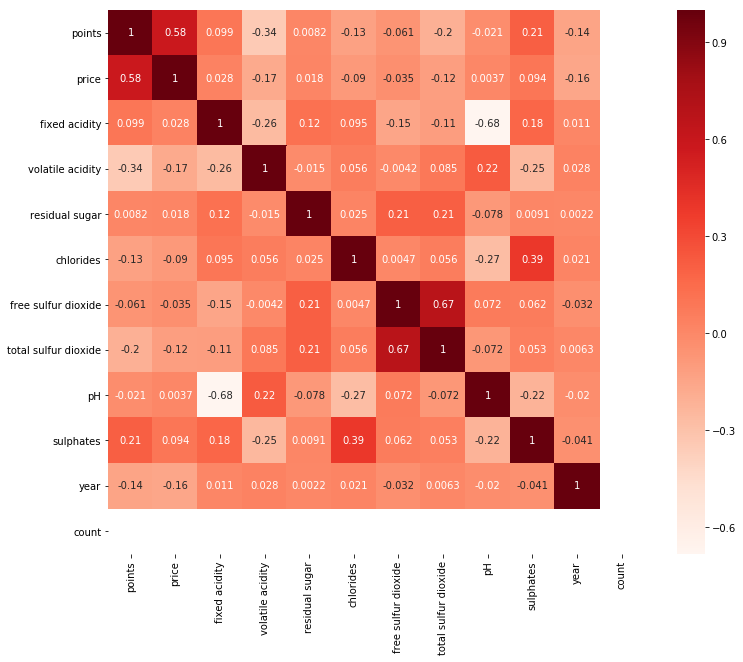

In [36]:
# corralation tabel voor dataset redwines
plt.figure(figsize=(12,10))
correlation_matrix = redwines.corr()
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

Het is belangrijk om inzicht te hebben in hoe de punten zijn verdeeld. Na een korte analyse kwamen we erachter dat alle punten zijn verdeeld tussen 80 en 100. Daarmee is een wijn van 80 punten opeens de slechtst beoordeelde wijn terwijl het lijkt alsof dit een redelijk hoge score is. In onderstaande bar plot is te zien hoe de punten zijn verdeeld 

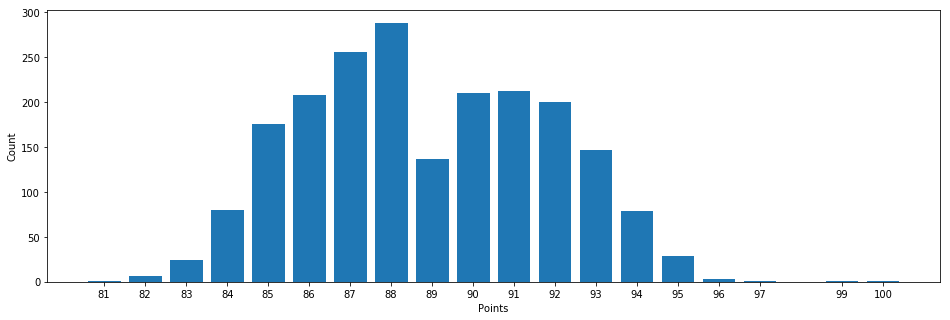

In [37]:
# punt verdeling
points = redwines.groupby('points').sum()
plt.figure(figsize=(16,5))
plt.xticks(points.index)
plt.bar(points.index, points['count'])
plt.xlabel('Points')
plt.ylabel('Count')
plt.show()

Wij hebben ook besloten om een paar box plotten te maken van specifieken waarden om zo te zien hoe die zijn verdeeld
Hier uit is te zien dat de pH relatief dicht bij elkaar licht en dat er niet veel waarden zijn die erveel afwijken

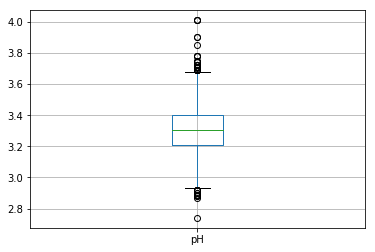

In [38]:
boxplot = redwines.boxplot('pH')

Hier uit is te zien dat het suiker gehalte veel waardes zijn die ver afwijken. Intresant genoeg zijn al deze waarden hoger dan de mediaan en zijn er weinig waarden lager

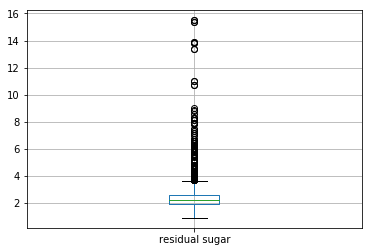

In [39]:
boxplot = redwines.boxplot('residual sugar')

We vroegen ons als groepje ook af wat de correlatie is tussen wijn prijs en gegeven punten. Je zou zeggen dat de duurdere wijnen ook beter beoordeeld moeten zijn. Het aantal punten zou dus moeten oplopen naarmate de prijs hoger wordt. Dit bleek ook enigzins het geval zoals in de onderstaande scatter plot te zien is. Het is soms ook lastig te zeggen aangezien het onderlinge verschil tussen gegeven punten niet erg hoog is. Er is per puntenaantal een gemiddeld van de prijs genomen, en dit gemiddelde wordt getoond per puntenaantal.

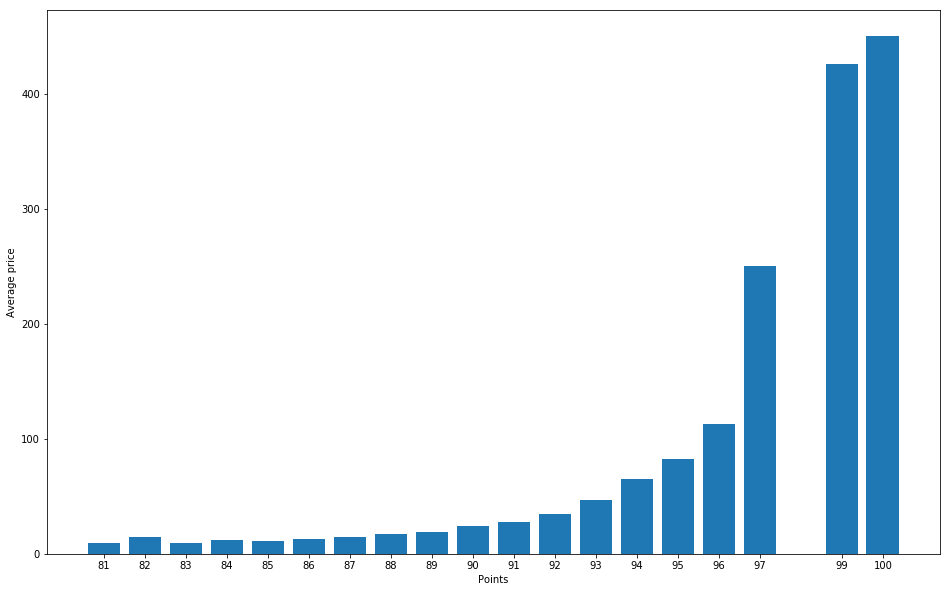

In [40]:
# Points comparison to average price
avg = redwines.groupby('points').sum()
avg['avg_price_per_point'] = avg['price'] / avg['count']
plt.figure(figsize=(16,10))
plt.xticks(avg.index)
plt.bar(avg.index, avg['avg_price_per_point'])
plt.xlabel('Points')
plt.ylabel('Average price')
plt.show()

Ook dachten we dat er misschien een verband tussen goedkope wijn en veel suiker zou zijn, i.v.m. het feit dat suiker een goedkope grondstof is. Dit bleek echter minder uit te maken dan we eerst dachten. Er is geen overduidelijk verband te vinden tussen lagere wijnprijzen en hogere suikergehaltes zoals in de onderstaande scatter plot te zien is.

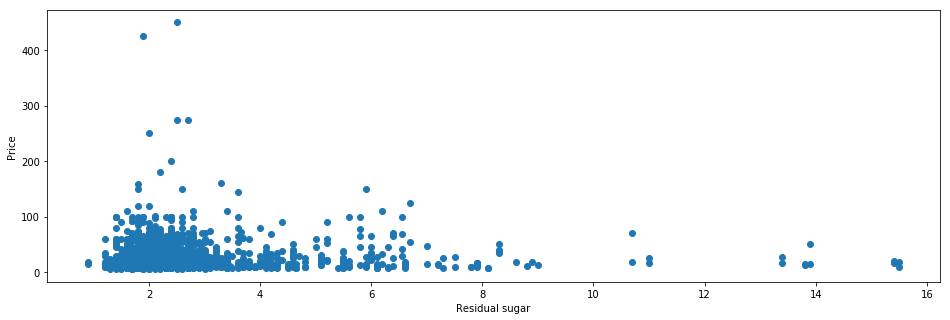

In [41]:
# Sugar comparison to price
plt.figure(figsize=(16,5))
plt.scatter(redwines['residual sugar'], redwines['price'])
plt.ylabel('Price')
plt.xlabel('Residual sugar')
plt.show()

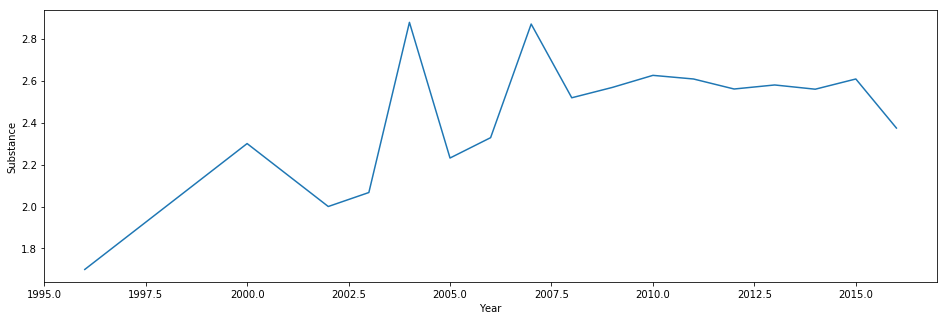

In [42]:
# Sugar increase over years
avg = redwines.groupby('year').sum()
avg['avg_increase_substance'] = avg['residual sugar'] / avg['count']
plt.figure(figsize=(16,5))
plt.plot(avg.index, avg['avg_increase_substance'])
plt.ylabel('Substance')
plt.xlabel('Year')
plt.show()

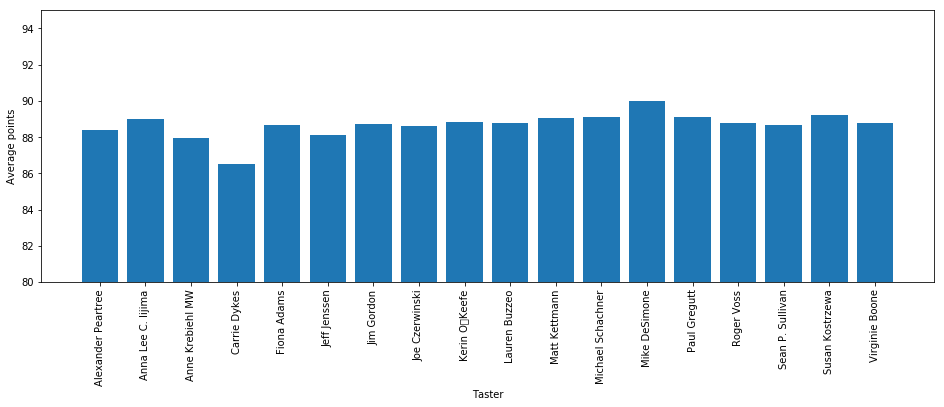

In [43]:
# Average scores per taster
avg = redwines.groupby('taster_name').sum()
avg['avg_taster_given_points'] = avg['points'] / avg['count']
plt.figure(figsize=(16,5))
axes = plt.gca()
axes.set_ylim([80,95])
plt.bar(avg.index, avg['avg_taster_given_points'])
plt.ylabel('Average points')
plt.xlabel('Taster')
plt.xticks(avg.index, rotation='vertical')
plt.show()

Ook hebben wij gekeken naar de correlatie punten en jaar. Goed is wel om te vermelde dat er weinig wijnen uit het jaar 1996 kwamen. Dus die scoren is gebaseerd op een zeer kleine testgroep. 

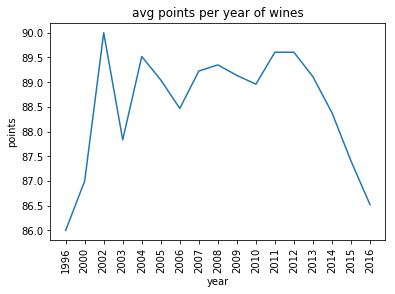

In [44]:
# voeg jaartal toe als aparte kolom, en verwijder nan rijen voor jaren (2465 naar 2461)

redwines['year'] = redwines['title'].str.extract(r"([1][9][9]\d|[2][0][0,1,2]\d)")

redwines = redwines[redwines['year'].notnull()]

# drop rows with nan value in it

redwines.dropna(inplace=True)

# adds how many wines are tested in a year

redwines['count'] = 1

#average of points given per year 

sum_points_per_year = redwines.groupby('year').sum()

sum_points_per_year['avg_points_per_year'] = sum_points_per_year['points'] / sum_points_per_year['count']


#avg points given per year
plt.plot(sum_points_per_year.index, sum_points_per_year['avg_points_per_year'])
plt.xticks(sum_points_per_year.index, sum_points_per_year.index, rotation='vertical')
plt.title('avg points per year of wines')
plt.xlabel('year')
plt.ylabel('points')
plt.show()

__CREATING THE MODEL FOR CORRELATION BETWEEN YEARS AND AVERAGE WEATHER CONDITIONS__

In [45]:
# ['Temperature', 'Dewpoint Temperature','Windspeed','Max Windspeed','Max Temperature','Min Temperature','Frost','Rain','Snow','Hail','Thunder']
# dependent and independent columns
dependent = redwines_with_yeartemperatures['points']
independent = redwines_with_yeartemperatures[['year','Temperature', 'Dewpoint Temperature','Windspeed','Max Windspeed','Max Temperature','Min Temperature','Frost','Rain','Snow','Hail','Thunder']]

# test and train set
X_train, X_test, y_train, y_test = train_test_split(independent, dependent, random_state=0, test_size=0.2)

# setting up and training model
model = LogisticRegression()
model.fit(X_train, y_train)

# testing and calculating accuracy
#print(model.predict(X_test))
print(model.score(X_test,y_test))

# LinearRegression 8%
# DecisionTreeClassifier 12%
# LogisticRegression 15%
# BayesianRidge 6%
# SVR 5%
# DecisionTreeRegressor 7%
# Ridge 5%

0.14563106796116504


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
